In [68]:
import sys
sys.path.append("..")
from  utilities import *

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]
sa.excel(data, path="../data/data_brand35.xlsx")

train_data, test_data = sa.divide_data_for_train_and_test(data=data, train_size=0.8)

sa.excel(train_data, path="../data/train_data.xlsx")
sa.excel(test_data, path="../data/test_data.xlsx")

model_brand35 = sa.modelization_with_backward_elimination(
    data_filtered_by_brand=train_data
)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

train_data = train_data[
    (train_data["variant"] == "flavoured")
    & (train_data["pack_size"] == "0 - 350 GR")
    & (train_data["supermarket"] == "supermarket-A")
]

# sa.excel(train_data, path="../data/train_data_filtered.xlsx")

auto_model = pm.auto_arima(
    train_data["volume_sales"], 
    seasonal=True,
    # D=None,
    trace=True,
    suppress_warnings=True,
)
# auto_model = pm.auto_arima(
#     train_data["volume_sales"],
#     seasonal=True,
#     m=12,
#     d=None,
#     D=None,
#     trace=True,
#     suppress_warnings=True,
# )


sarima = SARIMAX(
    train_data["volume_sales"],
    order=(5, 0, 0),
    seasonal_order=auto_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)
# sarima.summary()
# sarima.plot_diagnostics(figsize=(15, 12))

y_pred = sarima.get_forecast(steps=len(test_data)).predicted_mean
y_pred = pd.Series(y_pred, index=test_data.index)
y_pred = y_pred.to_frame(name="predicted_sales")
# y_pred["real_sales"] = test_data["volume.sales"].values
# y_pred["error"] = y_pred["predicted_sales"] - y_pred["real_sales"]
# y_pred["abs_error"] = y_pred["error"].abs()
# y_pred["abs_error"].mean(), y_pred["abs_error"].std()
print(y_pred.head(10))

## Propuesta de GPT

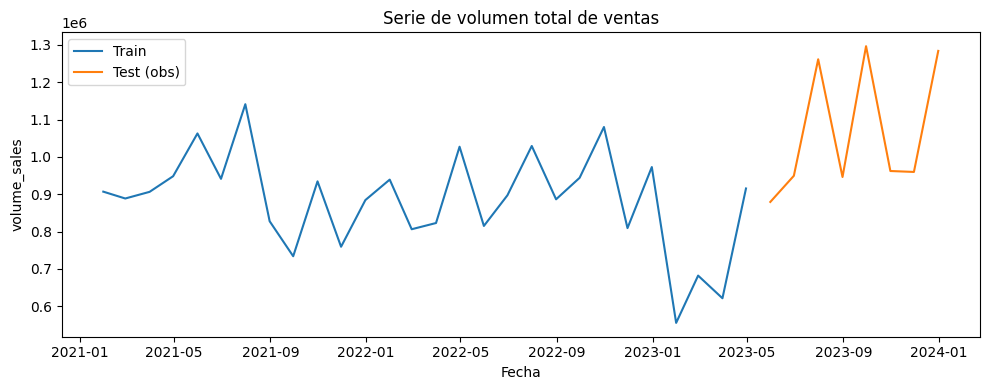

>> Mejor configuración: order=(0, 1, 2), seasonal_order=(0, 1, 1, 12), AIC=10.00
>> MAE (validación): 193,766 unidades


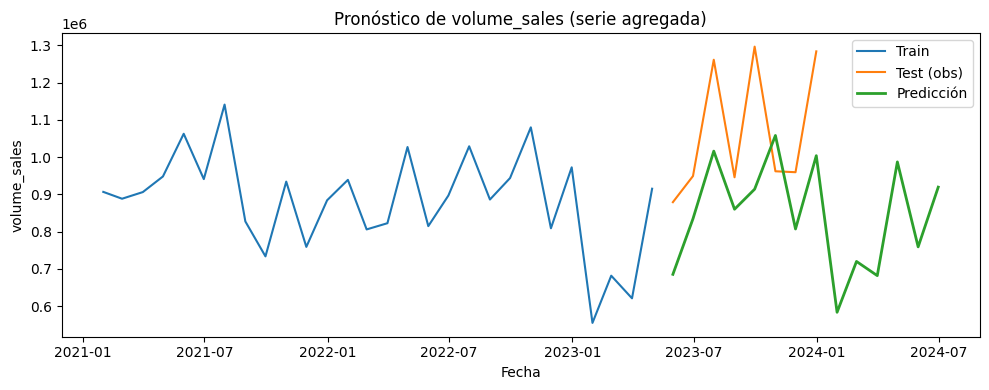

<function print>

In [ ]:
# ================================================================  #TODO: mo
# ARIMAX / SARIMAX forecasting de volume_sales (serie agregada)
# ================================================================
# Requisitos:
#   pip install pandas numpy matplotlib statsmodels openpyxl
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")  # evita warnings de statsmodels

# ------------------------------------------------
# 1. Cargar datos y asegurar frecuencia mensual
# ------------------------------------------------
df = pd.read_excel("../data/data_brand35.xlsx")  # <-- ajusta la ruta si es necesario
df["date"] = pd.to_datetime(df["date"])

# Volumen total + precio medio ponderado (se usa como exógena)
monthly = (
    df.groupby("date")
    .agg(
        volume_sales=("volume.sales", "sum"),
        price_weighted=(
            "price",  # media ponderada por volumen
            lambda x: np.average(x, weights=df.loc[x.index, "volume.sales"]),
        ),
    )
    .asfreq("M")  # fuerza índice a fin de mes (28, 30 o 31)
)

# ------------------------------------------------
# 2. División train / test
#    (últimos 5 meses como validación “out‑of‑sample”)
# ------------------------------------------------
# train = monthly.iloc[:-5]
# test = monthly.iloc[-5:] 

train, test = sa.divide_data_for_train_and_test(
    data=monthly, train_size=0.8
)  
X_train = train[["price_weighted"]]
X_test = test[["price_weighted"]]

plt.figure(figsize=(10, 4)) #FIXME: ajustar el grafico para que la prediccion empiece el mismo dia que termina el train
plt.plot(train.index, train["volume_sales"], label="Train")
plt.plot(test.index, test["volume_sales"], label="Test (obs)")
plt.title("Serie de volumen total de ventas")
plt.xlabel("Fecha")
plt.ylabel("volume_sales")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 3. Grid‑search SARIMAX
#    • order = (p,d,q)  con p∈0‑2, d∈0‑1, q∈0‑2
#    • seasonal_order = (P,1,Q,12) con P,Q∈0‑1
# ------------------------------------------------
pdq = [(p, d, q) for p in range(3) for d in range(2) for q in range(3)]
seasonal_pdq = [(P, 1, Q, 12) for P in range(2) for Q in range(2)]

best_aic = np.inf
best_order = None
best_seasonal = None

for order in pdq:
    for s_order in seasonal_pdq:
        try:
            model = SARIMAX(
                train["volume_sales"],
                order=order,
                seasonal_order=s_order,
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
                best_seasonal = s_order
        except Exception:
            continue

print(
    f">> Mejor configuración: order={best_order}, "
    f"seasonal_order={best_seasonal}, AIC={best_aic:.2f}"
)

# ------------------------------------------------
# 4. Ajuste final con la mejor configuración
# ------------------------------------------------
final_model = SARIMAX(
    train["volume_sales"],
    order=best_order,
    seasonal_order=best_seasonal,
    exog=X_train,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
final_results = final_model.fit(disp=False)

# ------------------------------------------------
# 5. Evaluación en el periodo de test
# ------------------------------------------------
test_pred = final_results.get_forecast(steps=len(test), exog=X_test).predicted_mean
mae = np.mean(np.abs(test["volume_sales"] - test_pred))
print(f">> MAE (validación): {mae:,.0f} unidades")

# ------------------------------------------------
# 6. Forecast futuro (ej. 6 meses)
#    – reutilizamos el último precio medio como proxy
# ------------------------------------------------
future_steps = 6
last_price = monthly["price_weighted"].iloc[-1]
future_dates = pd.date_range(
    monthly.index[-1] + pd.offsets.MonthEnd(1), periods=future_steps, freq="M"
)
future_exog = pd.DataFrame(
    {"price_weighted": [last_price] * future_steps}, index=future_dates
)

exog_forecast = pd.concat([X_test, future_exog])  # exógenas para test+futuro
forecast_res = final_results.get_forecast(steps=len(exog_forecast), exog=exog_forecast)
forecast_mean = forecast_res.predicted_mean

# ------------------------------------------------
# 7. Gráfico
# ------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(train.index, train["volume_sales"], label="Train")
plt.plot(test.index, test["volume_sales"], label="Test (obs)")
plt.plot(forecast_mean.index, forecast_mean, label="Predicción", lw=2)
plt.title("Pronóstico de volume_sales (serie agregada)")
plt.xlabel("Fecha")
plt.ylabel("volume_sales")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 8. Tabla con los 6 meses pronosticados
# ------------------------------------------------
forecast_table = forecast_mean[future_dates].to_frame(name="forecast_volume")
print